# **Data Preparation**

In [ ]:
import numpy as np
import pandas as pd
import platform
import os
import sys
import re
import time
import timeit
from datetime import datetime, timedelta, date
import glob
import configparser
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.manifold import TSNE
from collections import Counter
import plotly.graph_objects as go
#import fasttext
from gensim.models.word2vec import Word2Vec
from gensim.models.fasttext import FastText

In [ ]:
limit_corpus = 10000
seed = 42

In [ ]:
config = configparser.RawConfigParser()
config.read('config.ini')

#uri = config.get('MS AZURE', 'URI')

[]

<hr>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
colab_active = 'google.colab' in sys.modules
print("Colab Active: ", colab_active)

Colab Active:  True


#**Downloads**

In [ ]:
if colab_active is True:
  OS = platform.system()      # Operating System

  def data_download(file_to_download, gdrive_code, OS, uncompress = True):
    if not os.path.exists(file_to_download):
      os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
      if OS == "Linux" and uncompress:
          os.system('unzip -o -n "./'+file_to_download+'" -d '+os.path.dirname(file_to_download))
      return True
    else:
      return None

In [ ]:
if colab_active is True:
  out = data_download("./Senntiment_Social_Mood_Corpus_Tweets.zip", "11lopgQpkQ-UjwP62icelthzISG_fn2_5", OS)

## **Training Set**
Build the model training set starting from the sentipolc and happy parents datasets.

### Sentipolc

In [ ]:
train_sentipolc = pd.read_csv(f"./Senntiment_Social_Mood_Corpus_Tweets/training_set_sentipolc16.csv")
colnames_sentipolc = list(train_sentipolc.columns)

In [ ]:
test_sentipolc = pd.read_csv((f"./Senntiment_Social_Mood_Corpus_Tweets/test_set_sentipolc16_gold2000.csv"), on_bad_lines='skip', names = colnames_sentipolc)

In [ ]:
sentipolc = pd.concat([train_sentipolc, test_sentipolc])

In [ ]:
sentipolc['pol'] = 0

sentipolc.loc[(sentipolc['opos'] == 1) & (sentipolc['oneg'] == 0), 'pol'] = int(1)
sentipolc.loc[(sentipolc['opos'] == 0) & (sentipolc['oneg'] == 1), 'pol'] = int(2)
sentipolc.loc[(sentipolc['opos'] == 0) & (sentipolc['oneg'] == 0), 'pol'] = int(0)
sentipolc.loc[(sentipolc['opos'] == 1) & (sentipolc['oneg'] == 1), 'pol'] = int(3)

In [ ]:
sentipolc = sentipolc[-((sentipolc.opos==1) & (sentipolc.oneg==1))]
sentipolc = sentipolc.drop(['idtwitter','subj','iro','lpos','lneg','top','opos','oneg'], axis = 1)

class_counts_sp = sentipolc['pol'].value_counts()

In [ ]:
print(f'SENTIPOLC DF: \n - Positive: {class_counts_sp[1]} \n - Negative: {class_counts_sp[2]} \n - Neutral:  {class_counts_sp[0]}')

SENTIPOLC DF: 
 - Positive: 1919 
 - Negative: 3253 
 - Neutral:  3705


### Happy Parents

In [ ]:
happy_parents = pd.read_csv(f"./Senntiment_Social_Mood_Corpus_Tweets/gold_HappyParents.csv")

In [ ]:
happy_parents.loc[happy_parents['polarity'] == 'POS', 'pol'] = int(1)
happy_parents.loc[happy_parents['polarity'] == 'HUMPOS', 'pol'] = int(1)
happy_parents.loc[happy_parents['polarity'] == 'NEG', 'pol'] = int(2)
happy_parents.loc[happy_parents['polarity'] == 'HUMNEG', 'pol'] = int(2)
happy_parents.loc[happy_parents['polarity'] == 'MIXED', 'pol'] = int(0)

In [ ]:
happy_parents.drop(happy_parents[happy_parents['polarity'] == 'NONE'].index, inplace = True)

class_counts_hp = happy_parents['pol'].value_counts()

In [ ]:
print(f'HAPPY PARENTS DF: \n - Positive: {class_counts_hp[1]} \n - Negative: {class_counts_hp[2]} \n - Neutral:  {class_counts_hp[0]}')

HAPPY PARENTS DF: 
 - Positive: 642 
 - Negative: 672 
 - Neutral:  28


### FeelIt

In [ ]:
feelit = pd.read_csv(f"./Senntiment_Social_Mood_Corpus_Tweets/feelit.csv")

In [ ]:
sentipolc

,text,pol
0,Intanto la partita per Via Nazionale si compli...,2
1,"False illusioni, sgradevoli realtà Mario Monti...",2
2,"False illusioni, sgradevoli realtà #editoriale...",2
3,Mario Monti: Berlusconi risparmi all'Italia il...,2
4,Mario Monti: Berlusconi risparmi all'Italia il...,2
...,...,...
1937,@serracchiani @pdnetwork solo che poi arriva @...,2
1938,Anche prodotti alimentari tipici pugliesi in v...,0
1939,intensità di vita https://t.co/jv4aARxzhz,0
1941,@GliIntoccabili @nonleggerlo Ma Ferrero? il co...,2


In [ ]:
feelit['pol'] = feelit['label'].replace(-1, 2)
feelit['text'] = feelit['textClean']

feelit.drop(columns = ['Unnamed: 0', 'label', 'textClean', 'Words'], inplace = True)

### Full Training Set

In [ ]:
training_df = pd.concat([sentipolc, happy_parents, feelit], ignore_index = True)
training_df.drop(columns = ['polarity', 'sub_topic'], inplace = True)
training_df['pol'] = training_df['pol'].astype('int')

class_counts = training_df['pol'].value_counts()

In [ ]:
print(f'FULL TRAINING DF: \n - Positive: {class_counts[1]} \n - Negative: {class_counts[2]} \n - Neutral:  {class_counts[0]}')

FULL TRAINING DF: 
 - Positive: 3289 
 - Negative: 5234 
 - Neutral:  3733


<hr>

## **Text Preprocessing**

In [ ]:
for i in range(len(training_df)):
  training_df['text'][i]=re.sub(r'http\S+','URL',training_df['text'][i])
  training_df['text'][i]=re.sub(r'@\S+','TAG',training_df['text'][i])

In [ ]:
training_df.drop_duplicates(subset = ['text'], inplace = True)
class_counts_clean = training_df.pol.value_counts()

In [ ]:
print(f'FULL TRAINING DF (CLEAN): \n - Positive: {class_counts_clean[1]} \n - Negative: {class_counts_clean[2]} \n - Neutral:  {class_counts_clean[0]}')

FULL TRAINING DF (CLEAN): 
 - Positive: 3279 
 - Negative: 5212 
 - Neutral:  3710


In [ ]:
training_df.to_csv('training_set.csv', sep = ';', encoding = 'utf-8')

<hr>

## **Word Embedding Model**

In [ ]:
import tensorflow as tf
import gensim
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [ ]:
class GPUWord2VecCallback(gensim.models.callbacks.CallbackAny2Vec):
    def on_epoch_start(self, model):
        model.trainables.syn1neg = tf.convert_to_tensor(model.trainables.syn1neg, dtype=tf.float32)
        model.trainables.syn1 = tf.convert_to_tensor(model.trainables.syn1, dtype=tf.float32)

In [ ]:
start_date: date = date(2020,1,1)
end_date  : date = date(2020,5,31)

In [ ]:
date_list = []

current_date = start_date
iteration = 1

while current_date <= end_date:
    date_list.append(f'{current_date.year}-{current_date.month:02d}-{current_date.day:02d}')
    current_date += timedelta(days=1)
    iteration += 1

import tweet corpus

In [ ]:
dfs = []

for date in date_list:
    df_date = pd.read_csv(f'./Senntiment_Social_Mood_Corpus_Tweets/corpus_tweets/{date}.csv', sep=';', encoding='ISO-8859-1')
    dfs.append(df_date)

In [ ]:
raw_df = pd.concat(dfs, ignore_index = True)

Train the unsupervised word embedding model

In [ ]:
if limit_corpus is not None:
    sentences = raw_df['testo'].sample(limit_corpus, random_state = seed)
else:
    sentences = raw_df['testo']

In [ ]:
word_lists = list(map(lambda text: str(text).split(), sentences.values))

In [ ]:
start_time = timeit.default_timer()
embedding_model = Word2Vec(word_lists, vector_size=300, window=8, min_count=1, workers=4, sg=0, epochs=1)


#embedding_model = Word2Vec(word_lists, vector_size=300, window=8, min_count=1, workers=1, compute_loss=True)
#embedding_model.build_vocab(word_lists)
#embedding_model.train(word_lists, total_examples=embedding_model.corpus_count, epochs=30, compute_loss=True, callbacks=[GPUWord2VecCallback()])

print("Elapsed Embeddings Training Time: ", timeit.default_timer()-start_time)

Elapsed Embeddings Training Time:  1.6366459350001605


In [ ]:
embedding_model.save("corpus_2_not_utf_w2v.bin")

In [ ]:
!pip install gensim fasttext

In [ ]:
import fasttext
import gensim

In [ ]:
start_time = timeit.default_timer()
fasttext_model = FastText(word_lists, vector_size=300, window=8, min_count=1, workers=4, sg=0, epochs=1)
#fasttext_model = fasttext.train_unsupervised(word_lists, epoch=1, ws=8, min_count = 1, dim=300)
#word_repr=fasttext.train_unsupervised(word_lists,'cbow', dim=300, epoch=1)
print("Elapsed Embeddings Training Time: ", timeit.default_timer()-start_time)

Elapsed Embeddings Training Time:  23.393442440999934


In [ ]:
fasttext_model.save("corpus_2_not_utf.bin")

Visualize the embedding space

In [ ]:
def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False, topn = 20):

  fig = plt.figure(figsize=(20, 17), dpi=80)
  tot_words = [root_word] + [tupla[0] for tupla in model.wv.most_similar(root_word, topn=topn)]
  X = model.wv[tot_words]

  if plot_3d:
    pca = TSNE(perplexity=topn, n_components=3, init='pca')

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])

    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

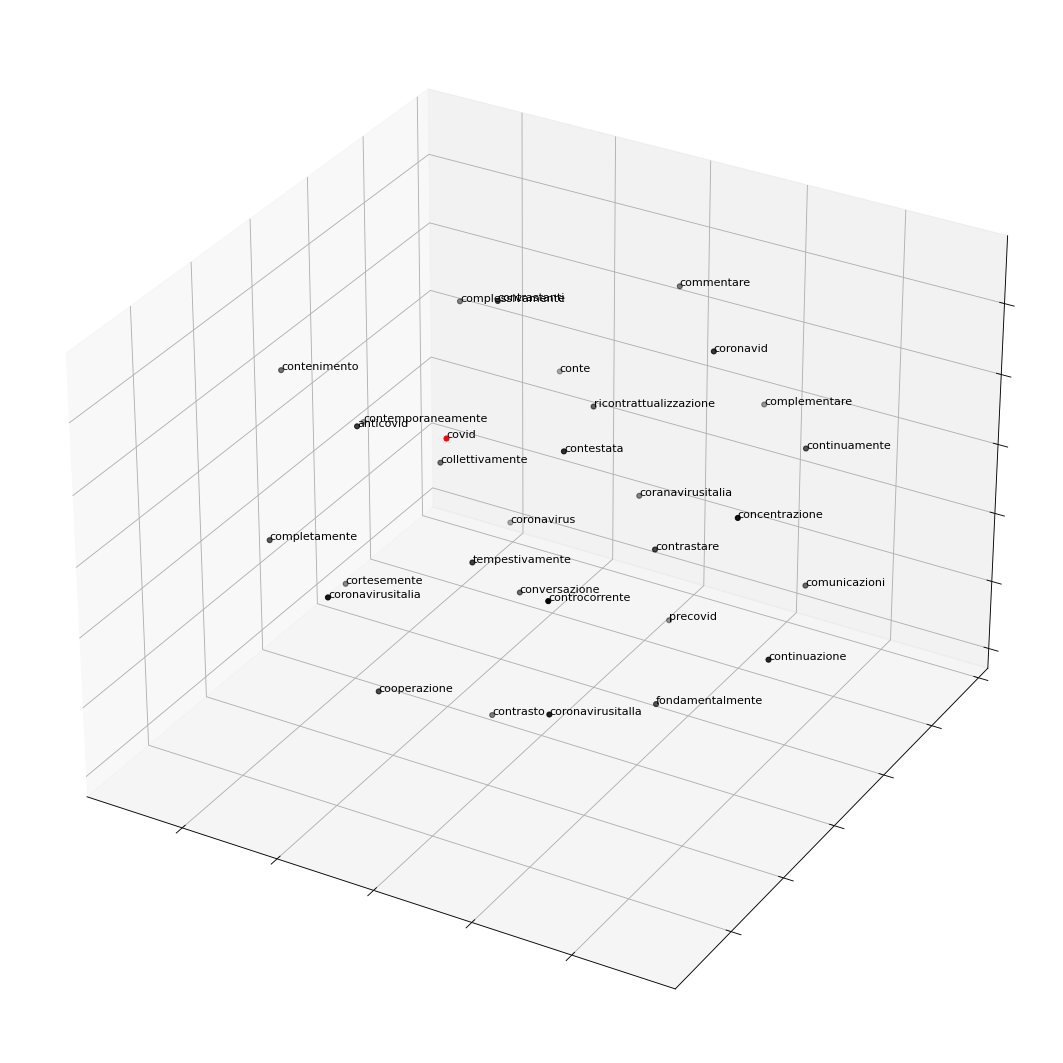

In [ ]:
embedding_space_visualization("covid", fasttext_model, topn = 30)

<hr>